In [46]:
import pickle
import json 
import os
import matplotlib.pyplot as plt
from SoccerNet.utils import getListGames

In [83]:
# pickle to results format
def process_results(data):
    vidxs = sorted(list(set(data['video-id'])))
    results_dict = {}
    for vidx in vidxs:
        results_dict[vidx] = []

    for vidx, start, end, label, score in zip(
            data['video-id'],
            data['t-start'],
            data['t-end'],
            data['label'],
            data['score']
        ):
            results_dict[vidx].append(
                {
                    "label" : int(label),
                    "score" : float(score),
                    "segment": [float(start), float(end)],
                }
            )
    return results_dict

In [36]:
#get gt labels filename
def get_gt_labels(game):
    temp = game.split("/")[:-1]
    replacement = temp[-1].replace("_", " ")
    temp[-1] = replacement
    file = "/home/csgrad/akumar58/soccernet/spotting_data/spotting_video/" + "/".join(temp)+"/Labels-v2.json"
    return file

#get pred and gt data
def get_act_data(results_dict, checkfile):
    pred_data = []
    gt_data = []
    temp = checkfile.split("/")[:-1]
    file = (temp[-1].replace(" ","_"))
    temp[-1] = file
    pred_file = "AA".join(temp)
    halfs = ["1_baidu_soccer_embeddings_", "2_baidu_soccer_embeddings_"]
    splits = ["train", "test", "val"]
    h = True
    for half in halfs:
        for split in splits:
            name = pred_file+"AA"+half+split
            if name in results_dict:
                for annot in results_dict[name]:
                    pred_data.append(annot)
                if h:
                    print("Found 1st half")
                    h = False
                else:
                    print("Found 2nd half")

                #read gt label here
                game = name.split("224p")[0][:-4]
                game = game.replace("AA","/")
                assert "GT file exists " ,os.path.exists(get_gt_labels(game))
                if not gt_data:
                    f = open(get_gt_labels(game))
                    gt_data.append(json.load(f))
                    # print("GT data loaded")
                # else:
                #     continue
                    # print("GT data already loaded")
    return pred_data, gt_data  

def get_socc_data(result_data, testfile):
    pred_data = []
    gt_data = []
    pred_data.append(result_data[testfile])
    f = open(testfile+"/Labels-v2.json")
    gt_data.append(json.load(f))
    return pred_data, gt_data                                        

In [139]:
# Create timeline plot
def makeplot(pred, gt, ranges, delta, align='center', fmt='socc'):
    label2idx = {
    "Penalty":0,"Kick-off":1,"Goal":2,"Substitution":3,"Offside":4,"Shots on target":5,
                                "Shots off target":6,"Clearance":7,"Ball out of play":8,"Throw-in":9,"Foul":10,
                                "Indirect free-kick":11,"Direct free-kick":12,"Corner":13,"Yellow card":14
                                ,"Red card":15,"Yellow->red card":16}

    actions = [action for action, idx in label2idx.items()]

    gt_start_times = [[] for i in range(17)]
    gt_end_times = [[] for i in range(17)]

    pred_start_times = [[] for i in range(17)]
    pred_end_times = [[] for i in range(17)]
    pred_scores = [[] for i in range(17)]

    
    #lod GT 
    c = 0     
    for annot in gt[0]['annotations']:
        label = label2idx[annot['label']]
        if annot['gameTime'][0] == '1':
            time = int(annot['position'])//(1000)
        else:
            time = int(annot['position'])//(1000) + 3000

        if align == 'center':
            c += 1
            # print(time-(delta/2), time, time+(delta/2))
            gt_start_times[label].append(time-(delta/2))
            gt_end_times[label].append(time+(delta/2))
        else:
            c += 1
            gt_start_times[label].append(time)
            gt_end_times[label].append(time+delta)

    print("gt count : ", c)

    p = 0
    if fmt == 'act':
        for annot in pred:
            label = annot['label']
            pred_start_times[label].append(annot['segment'][0])
            pred_end_times[label].append(annot['segment'][1])
            pred_scores[label].append(annot['score'])  
    elif fmt == 'socc':
        for annot in pred[0]['predictions']:
            label = label2idx[annot['label']]
            if annot['gameTime'][0] == '1':
                time = int(annot['position'])//(1000)
            else:
                time = int(annot['position'])//(1000) + 3000
            
            if align == 'center':
                p += 1
                # print(time-(delta/2), time, time+(delta/2))
                pred_start_times[label].append(time-(delta/2))
                pred_end_times[label].append(time+(delta/2))
                pred_scores[label].append(annot['confidence'])
            else:
                p += 1
                pred_start_times[label].append(time)
                pred_end_times[label].append(time+delta)
    
    print("pred count : ", p)

    fig, ax = plt.subplots()
    # GT
    for i in range(len(actions)):
        for j in range(len(gt_start_times[i])):
            ax.broken_barh([(gt_start_times[i][j], gt_end_times[i][j]-gt_start_times[i][j])], (i+0.1, 0.5), facecolors='blue', alpha=1.0)
    
    #Preds
    for i in range(len(actions)):
        for j in range(len(pred_start_times[i])):
            ax.broken_barh([(pred_start_times[i][j], pred_end_times[i][j]-pred_start_times[i][j])], (i+0.1, 0.8), facecolors='red', alpha=0.5)  #pred_scores[i]

    st, en = ranges
    ax.set_ylim(0, len(actions))
    ax.set_xlim(st, en)
    ax.set_xlabel('Gametime (s)')
    ax.set_yticks(range(len(actions)))
    ax.set_yticklabels(actions)

    ax.grid(True)
    plt.show()

In [5]:
# get list of test file names
# testgames = getListGames('test')
# testgames

In [85]:
def get_socc_data(result_data, testfile):
    pred_data = []
    gt_data = []
    pred_data.append(result_data[testfile])
    f = open(testfile+"/Labels-v2.json")
    gt_data.append(json.load(f))
    return pred_data, gt_data

def visualize(pkl, checkgame, fmt, ranges, delta, align):
    with open(pkl, 'rb') as f:
        data = pickle.load(f)
        
    if fmt == 'socc':
        print("Processing Soccernet pkl")
        testfile = '/home/csgrad/akumar58/soccernet/spotting_data/spotting_video/'+ checkgame
        pred, gt = get_socc_data(data, testfile)
        
    elif fmt == 'act':
        print("Processing Actionformer pkl")
        results_dict = process_results(data)
        pred, gt = get_act_data(results_dict, checkgame+'/')

    makeplot(pred, gt, ranges, delta, align=align, fmt=fmt)

Processing Soccernet pkl
gt count :  173
pred count :  211


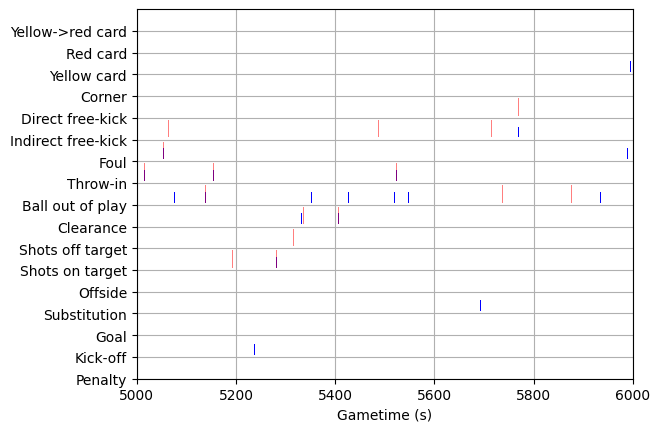

In [144]:
pkl_path =  '/home/csgrad/mbhosale/SoccerNet-Action-Spotting/soccernet_baidu_pretrained_with_regless/eval_results_sc_pp.pkl'
checkgame = 'england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal'
fmt = 'socc'
ranges = (5000, 6000)
delta = 1
align = 'center'
visualize(pkl_path, checkgame, fmt, ranges, delta, align)

In [ ]:
pkl_path =  '/home/csgrad/mbhosale/SoccerNet-Action-Spotting/soccernet_baidu_pretrained_with_regless/eval_results_sc_pp.pkl'
checkgame = 'england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal'
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

pred_data = []
testfile = '/home/csgrad/akumar58/soccernet/spotting_data/spotting_video/'+ checkgame
pred_data.append(data[testfile])
data



In [76]:
gt_data = []
checkgame = 'england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal'
testfile = '/home/csgrad/akumar58/soccernet/spotting_data/spotting_video/'+ checkgame

f = open(testfile+"/Labels-v2.json")
gt_data.append(json.load(f))

In [77]:
gt_data

[{'UrlLocal': 'england_epl/2014-2015/2015-05-17 - 18-00 Manchester United 1 - 1 Arsenal/',
  'UrlYoutube': '',
  'annotations': [{'gameTime': '1 - 00:00',
    'label': 'Kick-off',
    'position': '0',
    'team': 'home',
    'visibility': 'visible'},
   {'gameTime': '1 - 01:16',
    'label': 'Ball out of play',
    'position': '76376',
    'team': 'not applicable',
    'visibility': 'visible'},
   {'gameTime': '1 - 01:26',
    'label': 'Throw-in',
    'position': '86245',
    'team': 'away',
    'visibility': 'not shown'},
   {'gameTime': '1 - 03:48',
    'label': 'Ball out of play',
    'position': '228671',
    'team': 'not applicable',
    'visibility': 'visible'},
   {'gameTime': '1 - 03:54',
    'label': 'Throw-in',
    'position': '234838',
    'team': 'away',
    'visibility': 'visible'},
   {'gameTime': '1 - 04:11',
    'label': 'Ball out of play',
    'position': '251234',
    'team': 'not applicable',
    'visibility': 'visible'},
   {'gameTime': '1 - 04:17',
    'label': 'Th